# Ciência de Dados em Larga Escala
# Trabalho Prático - Performance Analysis
## Lara Sousa e Mariana Serrão

## Notebook 3 - Índice:
- Exploração da bibliotecas Rapids. Desta forma, vai-se recriar o estudo, mas alterando a implementação para uma abordagem usando esta biblioteca.
- Utilização do cProfile para análise de desempenho do código.
- Adaptação do estudo para um dataset com 2 ficheiros parquet e um dataset com 3 ficheiros parquet.
  
Este notebook foi executado no ambiente do Google Colab.

### Bibliotecas

In [2]:
!nvidia-smi  # this should display information about available GPUs


Sat Jun  8 16:11:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+-

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 481, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 481 (delta 143), reused 124 (delta 91), pack-reused 269
Receiving objects: 100% (481/481), 133.58 KiB | 1.69 MiB/s, done.
Resolving deltas: 100% (245/245), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 801.5 kB/s eta 0:00:00
***********************************************************************
Woo! Your instance has a Tesla T4 GPU!
We will install the latest stable RAPIDS via pip 24.4.*!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 537.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 MB 

In [ ]:
import cudf
cudf.__version__

'24.04.01'

In [ ]:
import cuml
cuml.__version__

'24.04.00'

In [ ]:
import cugraph
cugraph.__version__

'24.04.00'

In [ ]:
import cuspatial
cuspatial.__version__

'24.04.00'

In [ ]:
import cuxfilter
cuxfilter.__version__

'24.04.01'

In [ ]:
!pip install plotly-express

In [ ]:
# Importing required packages
import pandas as pd
import pyarrow
import numpy as np

# Check versions
print("pandas version:", pd.__version__)
print("pyarrow version:", pyarrow.__version__)
print("numpy version:", np.__version__)

pandas version: 2.0.3
pyarrow version: 14.0.2
numpy version: 1.25.2


In [ ]:
import time
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd

## Definição das Funções de Benchmark
##### Definiu-se duas funções:

 - benchmark: mede a duração da execução de uma função específica aplicada a um DataFrame e armazena os resultados de tempo e nome da tarefa num dicionário de benchmarks.
 - get_results: converte o dicionário de benchmarks num DataFrame do pandas para facilitar a visualização e análise dos resultados.

In [ ]:
def benchmark(f, df, benchmarks, name, **kwargs):
    """Benchmark the given function against the given DataFrame.

    Parameters
    ----------
    f: function to benchmark
    df: data frame
    benchmarks: container for benchmark results
    name: task name

    Returns
    -------
    Duration (in seconds) of the given operation
    """
    start_time = time.time()
    ret = f(df, **kwargs)
    benchmarks['duration'].append(time.time() - start_time)
    benchmarks['task'].append(name)
    print(f"{name} took: {benchmarks['duration'][-1]} seconds")
    return benchmarks['duration'][-1]

def get_results(benchmarks):
    """Return a pandas DataFrame containing benchmark results."""
    return pd.DataFrame.from_dict(benchmarks)

# RAPIDS

### Inicialização e Carregamento de Dados
Inicializou-se o cliente Dask-CUDA utilizando dask_cuda.LocalCUDACluster(), que permite a execução de operações distribuídas em GPUs NVIDIA, aproveitando o poder de processamento dessas unidades para realizar operações de forma paralela. Em seguida, realizou-se a leitura de um arquivo Parquet utilizando a biblioteca cuDF, que faz parte do conjunto de ferramentas Rapids. Para medir o desempenho das operações realizadas com a biblioteca Rapids, foram inicializados três dicionários de benchmark: rapids_benchmarks, rapids_benchmarks_filtered e rapids_benchmarks_cache. Cada um desses dicionários possui duas chaves: 'duration', para armazenar a duração das operações em segundos, e 'task', para descrever a tarefa realizada durante a medição de desempenho.

In [ ]:
import os
import cudf
import dask_cuda
import dask_cudf
import time


# Inicialize o cliente Dask-CUDA
client = dask_cuda.LocalCUDACluster()

# Leitura do arquivo Parquet usando cuDF
parquet_file = 'Ficheiros/taxi_csv/yellow_tripdata_2009-01.parquet'
rapids_data = dask_cudf.read_parquet(parquet_file)

# Inicialize os dicionários de benchmark
rapids_benchmarks = {
    'duration': [],  # em segundos
    'task': [],
}
rapids_benchmarks_filtered = {
    'duration': [],  # em segundos
    'task': [],
}
rapids_benchmarks_cache = {
    'duration': [],  # em segundos
    'task': [],
}

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36015 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:34389
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:36015/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33077'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:42509', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:42509
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:35454


### Listagem de Colunas
Renomeou-se as colunas do DataFrame Dask para minúsculas, alinhando-as com as funções que foram criadas posteriormente para manipulação desses dados e imprimiu-se a lista de colunas do DataFrame Dask para verificar o carregamento correto.

In [ ]:
rapids_data = rapids_data.rename(columns=str.lower)
columns_list = rapids_data.columns
print(columns_list)

Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')


### Definição das Funções de Operações
Foram definidas várias funções que realizam operações de análise de dados no DataFrame Dask-CuDF, aproveitando as capacidades da biblioteca Rapids. Estas operações incluem contagem de linhas, cálculo de média, desvio padrão, soma e produto de colunas, contagem de valores, operações aritméticas complexas e estatísticas de agrupamento. Além disso, foram criadas funções para junção de dados, permitindo a combinação eficiente de diferentes conjuntos de dados.

In [ ]:
def read_file_parquet(df=None):
    return dask_cudf.read_parquet('Ficheiros/taxi_csv/yellow_tripdata_2009-01.parquet')

def count(df=None):
    return len(df)

def count_index_length(df=None):
    return len(df.index)

def mean(df):
    return df.fare_amt.mean().compute()

def standard_deviation(df):
    return df.fare_amt.std().compute()

def mean_of_sum(df):
    return (df.fare_amt + df.tip_amt).mean().compute()

def sum_columns(df):
    return (df.fare_amt + df.tip_amt).compute()

def mean_of_product(df):
    return (df.fare_amt * df.tip_amt).mean().compute()

def product_columns(df):
    return (df.fare_amt * df.tip_amt).compute()

def value_counts(df):
    return df.fare_amt.value_counts().compute()

def mean_of_complicated_arithmetic_operation(df):
    theta_1 = df.start_lon
    phi_1 = df.start_lat
    theta_2 = df.end_lon
    phi_2 = df.end_lat
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return ret.mean().compute()

def complicated_arithmetic_operation(df):
    theta_1 = df.start_lon
    phi_1 = df.start_lat
    theta_2 = df.end_lon
    phi_2 = df.end_lat
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return ret.compute()

def groupby_statistics(df):
    return df.groupby(by='passenger_count').agg(
      {
        'fare_amt': ['mean', 'std'],
        'tip_amt': ['mean', 'std']
      }
    ).compute()


other = groupby_statistics(rapids_data)
other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])

def join_count(df, other):
    return len(dd.merge(df, other, left_index=True, right_index=True))

def join_data(df, other):
    return dd.merge(df, other, left_index=True, right_index=True).compute()

### Execução dos Benchmarks
São realizados benchmarks numa série de funções que operam em um DataFrame Dask-CuDF, utilizando a biblioteca Rapids. Para cada função, é medido o tempo de execução e o resultado é armazenado num conjunto de benchmarks (`rapids_benchmarks`).

In [ ]:
benchmark(read_file_parquet, df=None, benchmarks=rapids_benchmarks, name='read file')
benchmark(count, df=rapids_data, benchmarks=rapids_benchmarks, name='count')
benchmark(count_index_length, df=rapids_data, benchmarks=rapids_benchmarks, name='count index length')
benchmark(mean, df=rapids_data, benchmarks=rapids_benchmarks, name='mean')
benchmark(standard_deviation, df=rapids_data, benchmarks=rapids_benchmarks, name='standard deviation')
benchmark(mean_of_sum, df=rapids_data, benchmarks=rapids_benchmarks, name='mean of columns addition')
benchmark(sum_columns, df=rapids_data, benchmarks=rapids_benchmarks, name='addition of columns')
benchmark(mean_of_product, df=rapids_data, benchmarks=rapids_benchmarks, name='mean of columns multiplication')
benchmark(product_columns, df=rapids_data, benchmarks=rapids_benchmarks, name='multiplication of columns')
benchmark(value_counts, df=rapids_data, benchmarks=rapids_benchmarks, name='value counts')
benchmark(mean_of_complicated_arithmetic_operation, df=rapids_data, benchmarks=rapids_benchmarks, name='mean of complex arithmetic ops')
benchmark(complicated_arithmetic_operation, df=rapids_data, benchmarks=rapids_benchmarks, name='complex arithmetic ops')
benchmark(groupby_statistics, df=rapids_data, benchmarks=rapids_benchmarks, name='groupby statistics')
benchmark(join_count, df=rapids_data, benchmarks=rapids_benchmarks, name='join count', other=other)
benchmark(join_data, df=rapids_data, benchmarks=rapids_benchmarks, name='join', other=other)

read file took: 0.023916959762573242 seconds
count took: 3.3087081909179688 seconds
count index length took: 1.1148946285247803 seconds
mean took: 1.1757397651672363 seconds
standard deviation took: 1.3825926780700684 seconds
mean of columns addition took: 1.495229959487915 seconds
addition of columns took: 2.035428285598755 seconds
mean of columns multiplication took: 6.0837438106536865 seconds
multiplication of columns took: 3.5238139629364014 seconds
value counts took: 1.289654016494751 seconds
mean of complex arithmetic ops took: 2.2033305168151855 seconds
complex arithmetic ops took: 1.6293137073516846 seconds
groupby statistics took: 1.6186583042144775 seconds
join count took: 13.153370380401611 seconds
join took: 1.2282414436340332 seconds


1.2282414436340332

### Salvar Resultados

In [ ]:
# Obter os resultados e remover duplicatas
rapids_res_temp = get_results(rapids_benchmarks).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(rapids_res_temp)

# Definir o nome do arquivo ou diretório
filename = 'Resultados/rapids_standard1'

# Salvar o DataFrame em formato Parquet
rapids_res_temp.to_parquet(filename)

print(f'O arquivo Parquet foi salvo em {filename}.')

                                 duration
task                                     
read file                        0.023917
count                            3.308708
count index length               1.114895
mean                             1.175740
standard deviation               1.382593
mean of columns addition         1.495230
addition of columns              2.035428
mean of columns multiplication   6.083744
multiplication of columns        3.523814
value counts                     1.289654
mean of complex arithmetic ops   2.203331
complex arithmetic ops           1.629314
groupby statistics               1.618658
join count                      13.153370
join                             1.228241
O arquivo Parquet foi salvo em Resultados/rapids_standard1.


### Operações com filtro
Uma expressão de filtro é definida utilizando operadores lógicos para selecionar linhas com valores de 'tip_amt' entre 1 e 5, inclusive. Em seguida, é definida uma função chamada filter_data que recebe um DataFrame como entrada e retorna as linhas que satisfazem a expressão de filtro. Esta função utiliza a expressão de filtro previamente definida para filtrar o DataFrame fornecido.

In [ ]:
# Expressão de filtro para cuDF
expr_filter = (rapids_data.tip_amt >= 1) & (rapids_data.tip_amt <= 5)

def filter_data(df):
    return df[expr_filter]

rapids_filtered = filter_data(rapids_data)

print(rapids_filtered)

<dask_cudf.DataFrame | 7 tasks | 1 npartitions>


Novamente, foram executadas as funções de benchmark definidas anteriormente, mas desta vez aplicadas ao DataFrame Dask filtrado, sendo que os resultados são guardados no dicionário `rapids_benchmarks_filtered`.

In [ ]:
benchmark(read_file_parquet, df=None, benchmarks=rapids_benchmarks_filtered, name='read file')
benchmark(count, rapids_filtered, benchmarks=rapids_benchmarks_filtered, name='count')
benchmark(count_index_length, rapids_filtered, benchmarks=rapids_benchmarks_filtered, name='count index length')
benchmark(mean, rapids_filtered, benchmarks=rapids_benchmarks_filtered, name='mean')
benchmark(standard_deviation, rapids_filtered, benchmarks=rapids_benchmarks_filtered, name='standard deviation')
benchmark(mean_of_sum, rapids_filtered, benchmarks=rapids_benchmarks_filtered, name='mean of columns addition')
benchmark(sum_columns, df=rapids_filtered, benchmarks=rapids_benchmarks_filtered, name='addition of columns')
benchmark(mean_of_product, rapids_filtered, benchmarks=rapids_benchmarks_filtered, name='mean of columns multiplication')
benchmark(product_columns, df=rapids_filtered, benchmarks=rapids_benchmarks_filtered, name='multiplication of columns')
benchmark(mean_of_complicated_arithmetic_operation, rapids_filtered, benchmarks=rapids_benchmarks_filtered, name='mean of complex arithmetic ops')
benchmark(complicated_arithmetic_operation, rapids_filtered, benchmarks=rapids_benchmarks_filtered, name='complex arithmetic ops')
benchmark(value_counts, rapids_filtered, benchmarks=rapids_benchmarks_filtered, name='value counts')
benchmark(groupby_statistics, rapids_filtered, benchmarks=rapids_benchmarks_filtered, name='groupby statistics')

other = groupby_statistics(rapids_filtered)
other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])

benchmark(join_count, rapids_filtered, benchmarks=rapids_benchmarks_filtered, name='join count', other=other)
benchmark(join_data, rapids_filtered, benchmarks=rapids_benchmarks_filtered, name='join', other=other)


read file took: 0.018416881561279297 seconds
count took: 1.294355869293213 seconds
count index length took: 1.1725490093231201 seconds
mean took: 1.2128713130950928 seconds
standard deviation took: 1.1974925994873047 seconds
mean of columns addition took: 1.1900784969329834 seconds
addition of columns took: 1.2575984001159668 seconds
mean of columns multiplication took: 1.2183926105499268 seconds
multiplication of columns took: 1.4176075458526611 seconds
mean of complex arithmetic ops took: 1.5985183715820312 seconds
complex arithmetic ops took: 1.7330965995788574 seconds
value counts took: 1.5979905128479004 seconds
groupby statistics took: 1.5169727802276611 seconds
join count took: 1.2581629753112793 seconds
join took: 1.3031716346740723 seconds


1.3031716346740723

### Salvar Resultados

In [ ]:
# Obter os resultados e remover duplicatas
rapids_res_filtered = get_results(rapids_benchmarks_filtered).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(rapids_res_filtered)

# Definir o nome do arquivo ou diretório
filename_filter = 'Resultados/rapids_filtered1'

# Salvar o DataFrame em formato Parquet
rapids_res_filtered.to_parquet(filename_filter)

print(f'O arquivo Parquet foi salvo em {filename_filter}.')


                                duration
task                                    
read file                       0.018417
count                           1.294356
count index length              1.172549
mean                            1.212871
standard deviation              1.197493
mean of columns addition        1.190078
addition of columns             1.257598
mean of columns multiplication  1.218393
multiplication of columns       1.417608
mean of complex arithmetic ops  1.598518
complex arithmetic ops          1.733097
value counts                    1.597991
groupby statistics              1.516973
join count                      1.258163
join                            1.303172
O arquivo Parquet foi salvo em Resultados/rapids_filtered1.


### Operações com filtro e caching

Para otimizar o desempenho e acelarar futuras operações que envolvem o DataFrame Dask filtrado, foi aplicado caching. Através da função client.persist, armazenou-se os resultados do DataFrame filtrado em memória, permitindo um acesso mais rápido e eficiente aos dados. Em seguida, aguarda-se até que todas as futuras operações associadas ao DataFrame sejam concluídas usando a função wait.

In [6]:
# Adicione cache ao DataFrame
rapids_filtered = rapids_filtered.persist()
from distributed import wait
print('Aguardando até que todos os futuros sejam concluídos')
wait(rapids_filtered)
print('Todos os futuros foram concluídos')

Aguardando até que todos os futuros sejam concluídos
Todos os futuros foram concluídos


Mais uma vez, as funções de benchmark foram executadas, desta vez aplicadas ao DataFrame Rapids filtrado e com caching ativado. Cada função de operação é aplicada ao DataFrame filtrado, e o tempo de execução é registrado no dicionário de benchmarks específico para operações com caching (`rapids_benchmarks_cache`).

In [ ]:
benchmark(read_file_parquet, df=None, benchmarks=rapids_benchmarks_cache, name='read file')
benchmark(count, rapids_filtered, benchmarks=rapids_benchmarks_cache, name='count')
benchmark(count_index_length, rapids_filtered, benchmarks=rapids_benchmarks_cache, name='count index length')
benchmark(mean, rapids_filtered, benchmarks=rapids_benchmarks_cache, name='mean')
benchmark(standard_deviation, rapids_filtered, benchmarks=rapids_benchmarks_cache, name='standard deviation')
benchmark(mean_of_sum, rapids_filtered, benchmarks=rapids_benchmarks_cache, name='mean of columns addition')
benchmark(sum_columns, df=rapids_filtered, benchmarks=rapids_benchmarks_cache, name='addition of columns')
benchmark(mean_of_product, rapids_filtered, benchmarks=rapids_benchmarks_cache, name='mean of columns multiplication')
benchmark(product_columns, df=rapids_filtered, benchmarks=rapids_benchmarks_cache, name='multiplication of columns')
benchmark(mean_of_complicated_arithmetic_operation, rapids_filtered, benchmarks=rapids_benchmarks_cache, name='mean of complex arithmetic ops')
benchmark(complicated_arithmetic_operation, rapids_filtered, benchmarks=rapids_benchmarks_cache, name='complex arithmetic ops')
benchmark(value_counts, rapids_filtered, benchmarks=rapids_benchmarks_cache, name='value counts')
benchmark(groupby_statistics, rapids_filtered, benchmarks=rapids_benchmarks_cache, name='groupby statistics')

other = groupby_statistics(rapids_filtered)
other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])

benchmark(join_count, rapids_filtered, benchmarks=rapids_benchmarks_cache, name='join count', other=other)
benchmark(join_data, rapids_filtered, benchmarks=rapids_benchmarks_cache, name='join', other=other)


read file took: 0.026398897171020508 seconds
count took: 0.021665573120117188 seconds
count index length took: 0.023325443267822266 seconds
mean took: 0.061142683029174805 seconds
standard deviation took: 0.11518073081970215 seconds
mean of columns addition took: 0.07767295837402344 seconds
addition of columns took: 0.26806211471557617 seconds
mean of columns multiplication took: 0.06291580200195312 seconds
multiplication of columns took: 0.25323987007141113 seconds
mean of complex arithmetic ops took: 0.5302491188049316 seconds
complex arithmetic ops took: 0.6947851181030273 seconds
value counts took: 0.08575725555419922 seconds
groupby statistics took: 0.27285075187683105 seconds
join count took: 0.5199732780456543 seconds
join took: 0.17925238609313965 seconds


0.17925238609313965

### Salvar Resultados

In [ ]:
# Obter os resultados e remover duplicatas
rapids_res_cache = get_results(rapids_benchmarks_cache).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(rapids_res_cache)

# Definir o nome do arquivo ou diretório
filename_cache = 'Resultados/rapids_cache1'

# Salvar o DataFrame em formato Parquet
rapids_res_cache.to_parquet(filename_cache)

print(f'O arquivo Parquet foi salvo em {filename_cache}.')


                                duration
task                                    
read file                       0.026399
count                           0.021666
count index length              0.023325
mean                            0.061143
standard deviation              0.115181
mean of columns addition        0.077673
addition of columns             0.268062
mean of columns multiplication  0.062916
multiplication of columns       0.253240
mean of complex arithmetic ops  0.530249
complex arithmetic ops          0.694785
value counts                    0.085757
groupby statistics              0.272851
join count                      0.519973
join                            0.179252
O arquivo Parquet foi salvo em Resultados/rapids_cache1.


### Reinicialização de Client
Antes de passar para a próxima etapa, reiniciou-se o cliente Dask-CUDA para garantir que qualquer recurso alocado anteriormente fosse liberado e para começar com um estado limpo ao iniciar a utilização do Koalas.

In [ ]:
# Encerrar o cluster existente
client.close()

# Criar um novo cluster
client = dask_cuda.LocalCUDACluster()

print("O cliente foi reiniciado com sucesso.")


INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:34315'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:52730; closing.
INFO:distributed.scheduler:Remove worker <WorkerState 'tcp://127.0.0.1:46833', name: 0, status: closing, memory: 0, processing: 0> (stimulus_id='handle-worker-cleanup-1717681574.59611')
INFO:distributed.scheduler:Lost all workers
INFO:distributed.scheduler:Scheduler closing due to unknown reason...
INFO:distributed.scheduler:Scheduler closing all comms
/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34035 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:38983
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:34035/status
INFO:dis

O cliente foi reiniciado com sucesso.


# Repetição para datasets com 2 e 3 Ficheiros

Repetiu-se o estudo, mas agora selecionando uma amostra maior, com os dois primeiros do ano de 2009 (meses de Janeiro e Fevereiro) para uma amostra com 2 files, seguindo-se a leitura dos ficheiros parquet selecionados, os três primeiros meses do ano de 2009 para uma amostra composta por 3 files.

In [ ]:
import cudf
import dask_cudf

# Arquivos Parquet
parquet_files2 = ['Ficheiros/taxi_csv/yellow_tripdata_2009-01.parquet',
                 'Ficheiros/taxi_csv/yellow_tripdata_2009-02.parquet']

parquet_files3 = [
    'Ficheiros/taxi_csv/yellow_tripdata_2009-01.parquet',
    'Ficheiros/taxi_csv/yellow_tripdata_2009-02.parquet',
    'Ficheiros/taxi_csv/yellow_tripdata_2009-03.parquet'
]

# Leitura dos arquivos Parquet usando cudf e dask_cudf
rapids_data2 = dask_cudf.read_parquet(parquet_files2)
rapids_data3 = dask_cudf.read_parquet(parquet_files3)

# Inicialização dos dicionários de benchmark
rapids_benchmarks2 = {'duration': [], 'task': []}
rapids_benchmarks_filtered2 = {'duration': [], 'task': []}
rapids_benchmarks_cache2 = {'duration': [], 'task': []}

rapids_benchmarks3 = {'duration': [], 'task': []}
rapids_benchmarks_filtered3 = {'duration': [], 'task': []}
rapids_benchmarks_cache3 = {'duration': [], 'task': []}

### Listagem de Colunas

In [ ]:
# Para rapids_data2
rapids_data2 = rapids_data2.rename(columns=str.lower)
columns_list2 = rapids_data2.columns
print(columns_list2)

# Para rapids_data3
rapids_data3 = rapids_data3.rename(columns=str.lower)
columns_list3 = rapids_data3.columns
print(columns_list3)


Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')
Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')


In [ ]:
# Define a lista de dataframes RAPIDS
dfs = [rapids_data2, rapids_data3]

### Definição das Funções de Operações

In [ ]:
def count(df=None):
    return len(df)

def count_index_length(df=None):
    return len(df.index)

def mean(df):
    return df.fare_amt.mean().compute()

def standard_deviation(df):
    return df.fare_amt.std().compute()

def mean_of_sum(df):
    return (df.fare_amt + df.tip_amt).mean().compute()

def sum_columns(df):
    return (df.fare_amt + df.tip_amt).compute()

def mean_of_product(df):
    return (df.fare_amt * df.tip_amt).mean().compute()

def product_columns(df):
    return (df.fare_amt * df.tip_amt).compute()

def value_counts(df):
    return df.fare_amt.value_counts().compute()

def mean_of_complicated_arithmetic_operation(df):
    theta_1 = df.start_lon
    phi_1 = df.start_lat
    theta_2 = df.end_lon
    phi_2 = df.end_lat
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return ret.mean().compute()

def complicated_arithmetic_operation(df):
    theta_1 = df.start_lon
    phi_1 = df.start_lat
    theta_2 = df.end_lon
    phi_2 = df.end_lat
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return ret.compute()

def groupby_statistics(df):
    return df.groupby(by='passenger_count').agg(
      {
        'fare_amt': ['mean', 'std'],
        'tip_amt': ['mean', 'std']
      }
    ).compute()

for df in dfs:
    other = groupby_statistics(df)
    other.columns = pd.Index([e[0]+'' + e[1] for e in other.columns.tolist()])

def join_count(df, other):
    return len(dd.merge(df, other, left_index=True, right_index=True))

def join_data(df, other):
    return dd.merge(df, other, left_index=True, right_index=True).compute()

### Execução dos Benchmarks

In [ ]:
for i, df in enumerate(dfs):
    benchmark(count, df=df, benchmarks=globals()[f'rapids_benchmarks{i+2}'], name=f'count')
    benchmark(count_index_length, df=df, benchmarks=globals()[f'rapids_benchmarks{i+2}'], name=f'count index length')
    benchmark(mean, df=df, benchmarks=globals()[f'rapids_benchmarks{i+2}'], name=f'mean')
    benchmark(standard_deviation, df=df, benchmarks=globals()[f'rapids_benchmarks{i+2}'], name=f'standard deviation')
    benchmark(mean_of_sum, df=df, benchmarks=globals()[f'rapids_benchmarks{i+2}'], name=f'mean of columns addition')
    benchmark(sum_columns, df=df, benchmarks=globals()[f'rapids_benchmarks{i+2}'], name=f'addition of columns')
    benchmark(mean_of_product, df=df, benchmarks=globals()[f'rapids_benchmarks{i+2}'], name=f'mean of columns multiplication')
    benchmark(product_columns, df=df, benchmarks=globals()[f'rapids_benchmarks{i+2}'], name=f'multiplication of columns')
    benchmark(value_counts, df=df, benchmarks=globals()[f'rapids_benchmarks{i+2}'], name=f'value counts')
    benchmark(mean_of_complicated_arithmetic_operation, df=df, benchmarks=globals()[f'rapids_benchmarks{i+2}'], name=f'mean of complex arithmetic ops')
    benchmark(complicated_arithmetic_operation, df=df, benchmarks=globals()[f'rapids_benchmarks{i+2}'], name=f'complex arithmetic ops')
    benchmark(groupby_statistics, df=df, benchmarks=globals()[f'rapids_benchmarks{i+2}'], name=f'groupby statistics')
    #benchmark(join_count, df, benchmarks=globals()[f'rapids_benchmarks{i+2}'], name=f'join count {i+2}', other=other)
    #benchmark(join_data, df, benchmarks=globals()[f'rapids_benchmarks{i+2}'], name=f'join {i+2}', other=other)


count took: 2.384489059448242 seconds
count index length took: 2.190547227859497 seconds
mean took: 2.106889247894287 seconds
standard deviation took: 2.3914010524749756 seconds
mean of columns addition took: 2.5082201957702637 seconds
addition of columns took: 3.0929794311523438 seconds
mean of columns multiplication took: 2.2811532020568848 seconds
multiplication of columns took: 2.5770177841186523 seconds
value counts took: 2.2569425106048584 seconds
mean of complex arithmetic ops took: 2.4928200244903564 seconds
complex arithmetic ops took: 3.2771968841552734 seconds
groupby statistics took: 2.6779661178588867 seconds
count took: 3.7251901626586914 seconds
count index length took: 3.4873363971710205 seconds
mean took: 3.3906092643737793 seconds
standard deviation took: 3.607480049133301 seconds
mean of columns addition took: 3.481356620788574 seconds
addition of columns took: 5.3794333934783936 seconds
mean of columns multiplication took: 4.049201965332031 seconds
multiplication of

### Salvar Resultados

In [ ]:
# Obter os resultados e remover duplicatas para dask_data2
rapids_res_temp2 = get_results(rapids_benchmarks2).drop_duplicates(subset='task').set_index('task')

# Obter os resultados e remover duplicatas para dask_data3
rapids_res_temp3 = get_results(rapids_benchmarks3).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(rapids_res_temp2)
print(rapids_res_temp3)

# Definir o nome do arquivo ou diretório para dask_data2
filename2 = 'Resultados/rapids_standard2'

# Definir o nome do arquivo ou diretório para dask_data3
filename3 = 'Resultados/rapids_standard3'

# Salvar o DataFrame em formato Parquet para dask_data2
rapids_res_temp2.to_parquet(filename2)

# Salvar o DataFrame em formato Parquet para dask_data3
rapids_res_temp3.to_parquet(filename3)

print(f'O arquivo Parquet foi salvo em {filename2}.')
print(f'O arquivo Parquet foi salvo em {filename3}.')

                                duration
task                                    
count                           2.384489
count index length              2.190547
mean                            2.106889
standard deviation              2.391401
mean of columns addition        2.508220
addition of columns             3.092979
mean of columns multiplication  2.281153
multiplication of columns       2.577018
value counts                    2.256943
mean of complex arithmetic ops  2.492820
complex arithmetic ops          3.277197
groupby statistics              2.677966
                                duration
task                                    
count                           3.725190
count index length              3.487336
mean                            3.390609
standard deviation              3.607480
mean of columns addition        3.481357
addition of columns             5.379433
mean of columns multiplication  4.049202
multiplication of columns       4.471126
value counts    

### Operações com filtro

In [ ]:
def filter_data(df, expr_filter):
    return df[expr_filter]

# Expressões de filtro para dask_data2 e dask_data3
expr_filter2 = (rapids_data2['tip_amt'] >= 1) & (rapids_data2['tip_amt'] <= 5)
expr_filter3 = (rapids_data3['tip_amt'] >= 1) & (rapids_data3['tip_amt'] <= 5)

# Filtrar os dataframes dask_data2 e dask_data3
rapids_filter2 = filter_data(rapids_data2, expr_filter2)
rapids_filter3 = filter_data(rapids_data3, expr_filter3)


In [ ]:
# Lista de dataframes filtrados
rapids_filtered = [rapids_filter2, rapids_filter3]

In [ ]:
# Executar benchmarks nos dataframes filtrados
for i, df in enumerate(rapids_filtered):
    benchmark(count, df, benchmarks=globals()[f'rapids_benchmarks_filtered{i+2}'], name=f'filtered count')
    benchmark(count_index_length, df, benchmarks=globals()[f'rapids_benchmarks_filtered{i+2}'], name=f'filtered count index length')
    benchmark(mean, df, benchmarks=globals()[f'rapids_benchmarks_filtered{i+2}'], name=f'filtered mean')
    benchmark(standard_deviation, df, benchmarks=globals()[f'rapids_benchmarks_filtered{i+2}'], name=f'filtered standard deviation')
    benchmark(mean_of_sum, df, benchmarks=globals()[f'rapids_benchmarks_filtered{i+2}'], name=f'filtered mean of columns addition')
    benchmark(sum_columns, df, benchmarks=globals()[f'rapids_benchmarks_filtered{i+2}'], name=f'filtered addition of columns')
    benchmark(mean_of_product, df, benchmarks=globals()[f'rapids_benchmarks_filtered{i+2}'], name=f'filtered mean of columns multiplication')
    benchmark(product_columns, df, benchmarks=globals()[f'rapids_benchmarks_filtered{i+2}'], name=f'filtered multiplication of columns')
    benchmark(mean_of_complicated_arithmetic_operation, df, benchmarks=globals()[f'rapids_benchmarks_filtered{i+2}'], name=f'filtered mean of complex arithmetic ops')
    benchmark(complicated_arithmetic_operation, df, benchmarks=globals()[f'rapids_benchmarks_filtered{i+2}'], name=f'filtered complex arithmetic ops')
    benchmark(value_counts, df, benchmarks=globals()[f'rapids_benchmarks_filtered{i+2}'], name=f'filtered value counts')
    benchmark(groupby_statistics, df, benchmarks=globals()[f'rapids_benchmarks_filtered{i+2}'], name=f'filtered groupby statistics')


filtered count took: 2.499300479888916 seconds
filtered count index length took: 2.4231069087982178 seconds
filtered mean took: 2.6315948963165283 seconds
filtered standard deviation took: 2.5565125942230225 seconds
filtered mean of columns addition took: 2.5220649242401123 seconds
filtered addition of columns took: 2.371807098388672 seconds
filtered mean of columns multiplication took: 2.2875189781188965 seconds
filtered multiplication of columns took: 2.8252406120300293 seconds
filtered mean of complex arithmetic ops took: 2.5350043773651123 seconds
filtered complex arithmetic ops took: 4.38150429725647 seconds
filtered value counts took: 4.333573818206787 seconds
filtered groupby statistics took: 3.0287318229675293 seconds
filtered count took: 3.4097769260406494 seconds
filtered count index length took: 3.430727958679199 seconds
filtered mean took: 3.5106709003448486 seconds
filtered standard deviation took: 3.7556991577148438 seconds
filtered mean of columns addition took: 3.793946

### Salvar Resultados

In [ ]:
# Obter os resultados e remover duplicatas para dask_data2
rapids_res_filter2 = get_results(rapids_benchmarks_filtered2).drop_duplicates(subset='task').set_index('task')

# Obter os resultados e remover duplicatas para dask_data3
rapids_res_filter3 = get_results(rapids_benchmarks_filtered3).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(rapids_res_filter2)
print(rapids_res_filter3)

# Definir o nome do arquivo ou diretório para dask_data2
filename_filter2 = 'Resultados/rapids_filtered2'

# Definir o nome do arquivo ou diretório para dask_data3
filename_filter3 = 'Resultados/rapids_filtered3'

# Salvar o DataFrame em formato Parquet para dask_data2
rapids_res_filter2.to_parquet(filename_filter2)

# Salvar o DataFrame em formato Parquet para dask_data3
rapids_res_filter3.to_parquet(filename_filter3)

print(f'O arquivo Parquet foi salvo em {filename_filter2}.')
print(f'O arquivo Parquet foi salvo em {filename_filter3}.')


                                         duration
task                                             
filtered count                           2.499300
filtered count index length              2.423107
filtered mean                            2.631595
filtered standard deviation              2.556513
filtered mean of columns addition        2.522065
filtered addition of columns             2.371807
filtered mean of columns multiplication  2.287519
filtered multiplication of columns       2.825241
filtered mean of complex arithmetic ops  2.535004
filtered complex arithmetic ops          4.381504
filtered value counts                    4.333574
filtered groupby statistics              3.028732
                                         duration
task                                             
filtered count                           3.409777
filtered count index length              3.430728
filtered mean                            3.510671
filtered standard deviation              3.755699


### Operações com filtro e cache

In [ ]:
from dask.distributed import wait

# Adiciona caching e espera por cada conjunto de dataframes filtrados
for i, df in enumerate(rapids_filtered):
    rapids_filtered[i] = rapids_filtered[i].persist()
    print(f'Waiting until all futures for set {i+2} are finished')
    wait(rapids_filtered[i])
    print(f'All futures for set {i+2} are finished')


Waiting until all futures for set 2 are finished
All futures for set 2 are finished
Waiting until all futures for set 3 are finished
All futures for set 3 are finished


In [ ]:
# Executar benchmarks nos dataframes armazenados em cache
for i, df in enumerate(rapids_filtered):
    benchmark(count, df, benchmarks=globals()[f'rapids_benchmarks_cache{i+2}'], name=f'cache count')
    benchmark(count_index_length, df, benchmarks=globals()[f'rapids_benchmarks_cache{i+2}'], name=f'cache count index length')
    benchmark(mean, df, benchmarks=globals()[f'rapids_benchmarks_cache{i+2}'], name=f'cache mean')
    benchmark(standard_deviation, df, benchmarks=globals()[f'rapids_benchmarks_cache{i+2}'], name=f'cache standard deviation')
    benchmark(mean_of_sum, df, benchmarks=globals()[f'rapids_benchmarks_cache{i+2}'], name=f'cache mean of columns addition')
    benchmark(sum_columns, df, benchmarks=globals()[f'rapids_benchmarks_cache{i+2}'], name=f'cache addition of columns')
    benchmark(mean_of_product, df, benchmarks=globals()[f'rapids_benchmarks_cache{i+2}'], name=f'cache mean of columns multiplication')
    benchmark(product_columns, df, benchmarks=globals()[f'rapids_benchmarks_cache{i+2}'], name=f'cache multiplication of columns')
    benchmark(mean_of_complicated_arithmetic_operation, df, benchmarks=globals()[f'rapids_benchmarks_cache{i+2}'], name=f'cache mean of complex arithmetic ops')
    benchmark(complicated_arithmetic_operation, df, benchmarks=globals()[f'rapids_benchmarks_cache{i+2}'], name=f'cache complex arithmetic ops')
    benchmark(value_counts, df, benchmarks=globals()[f'rapids_benchmarks_cache{i+2}'], name=f'cache value counts')
    benchmark(groupby_statistics, df, benchmarks=globals()[f'rapids_benchmarks_cache{i+2}'], name=f'cache groupby statistics')


cache count took: 0.035059452056884766 seconds
cache count index length took: 0.030142545700073242 seconds
cache mean took: 0.06524109840393066 seconds
cache standard deviation took: 0.07306241989135742 seconds
cache mean of columns addition took: 0.0702354907989502 seconds
cache addition of columns took: 0.19933772087097168 seconds
cache mean of columns multiplication took: 0.08318328857421875 seconds
cache multiplication of columns took: 0.21251273155212402 seconds
cache mean of complex arithmetic ops took: 0.28420281410217285 seconds
cache complex arithmetic ops took: 0.588341474533081 seconds
cache value counts took: 0.08088493347167969 seconds
cache groupby statistics took: 0.32213735580444336 seconds


MemoryError: Parquet data was larger than the available GPU memory!

See the notes on split_row_groups in the read_parquet documentation.

Original Error: std::bad_alloc: out_of_memory: CUDA error at: /__w/rmm/rmm/include/rmm/mr/device/cuda_memory_resource.hpp:60: cudaErrorMemoryAllocation out of memory

Ao executar os benchmarks para o dataset com 3 ficheiros Parquet, ocorreu um erro de falta de memória (`MemoryError`). A mensagem de erro indicou que os dados Parquet eram maiores do que a memória disponível na GPU, resultando num erro de alocação de memória (`std::bad_alloc: out_of_memory: CUDA error`). Assim, não foi possível obter estes resultados e guardá-los.

### Salvar Resultados

In [ ]:
# Obter os resultados e remover duplicatas para os dataframes cacheados
rapids_res_cache2 = get_results(rapids_benchmarks_cache2).drop_duplicates(subset='task').set_index('task')
rapids_res_cache3 = get_results(rapids_benchmarks_cache3).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(rapids_res_cache2)
print(rapids_res_cache3)

# Definir o nome do arquivo ou diretório
filename_cache2 = 'Resultados/rapids_cache2'
filename_cache3 = 'Resultados/rapids_cache3'

# Salvar o DataFrame em formato Parquet
rapids_res_cache2.to_parquet(filename_cache2)
rapids_res_cache3.to_parquet(filename_cache3)

print(f'O arquivo Parquet foi salvo em {filename_cache2}.')
print(f'O arquivo Parquet foi salvo em {filename_cache3}.')


                                      duration
task                                          
cache count                           0.035059
cache count index length              0.030143
cache mean                            0.065241
cache standard deviation              0.073062
cache mean of columns addition        0.070235
cache addition of columns             0.199338
cache mean of columns multiplication  0.083183
cache multiplication of columns       0.212513
cache mean of complex arithmetic ops  0.284203
cache complex arithmetic ops          0.588341
cache value counts                    0.080885
cache groupby statistics              0.322137
Empty DataFrame
Columns: [duration]
Index: []
O arquivo Parquet foi salvo em Resultados/rapids_cache2.
O arquivo Parquet foi salvo em Resultados/rapids_cache3.


### Medição com cProfile

**cProfile** é um módulo integrado do Python utilizado para medir o desempenho de programas, que permite analisar o tempo gasto em cada função, identificando gargalos e oportunidades de otimização. O cProfile gera dados detalhados que podem ser usados para entender melhor o comportamento do código e melhorar a sua eficiência.

Neste relatório, o `cProfile` é utilizado para analisar e otimizar um conjunto de operações realizadas num DataFrame carregado a partir de um arquivo Parquet. O código foi executado num Jupyter Notebook, e as etapas principais incluíram a **execução das operações** e a **coleta de dados de profiling**.

In [ ]:
import cProfile
import matplotlib.pyplot as plt
from io import StringIO
import pstats

**Função de Benchmarking com cProfile:**

Desenvolveu-se uma função de benchmarking (`benchmark_with_cprofile`) que mede a duração da execução de cada operação e utiliza o cProfile para coletar dados detalhados sobre o desempenho.

In [ ]:
# Define your benchmark function to use cProfile
def benchmark_with_cprofile(f, df, benchmarks, name, **kwargs):
    """Mede a duração da execução de uma função específica usando cProfile"""
    pr = cProfile.Profile()
    pr.enable()

    start_time = time.time()
    ret = f(df, **kwargs)
    benchmarks['duration'].append(time.time() - start_time)
    benchmarks['task'].append(name)
    print(f"{name} took: {benchmarks['duration'][-1]} seconds")

    pr.disable()
    pr.print_stats(sort='cumtime')  # Print profiling results sorted by cumulative time

    return benchmarks['duration'][-1]

In [ ]:
# Initialize dictionaries to store benchmark results
rapids_benchmarks_cprofile = {'duration': [], 'task': []}

**Executando as benchmarks para a biblioteca Rapids em operações com dados completos, usando CProfile**

In [ ]:
# Execute benchmarks on operations with cProfile
benchmark_with_cprofile(read_file_parquet, df=None, benchmarks=rapids_benchmarks_cprofile, name='read file')
benchmark_with_cprofile(count, df=rapids_data, benchmarks=rapids_benchmarks_cprofile, name='count')
benchmark_with_cprofile(count_index_length, df=rapids_data, benchmarks=rapids_benchmarks_cprofile, name='count index length')
benchmark_with_cprofile(mean, df=rapids_data, benchmarks=rapids_benchmarks_cprofile, name='mean')
benchmark_with_cprofile(standard_deviation, df=rapids_data, benchmarks=rapids_benchmarks_cprofile, name='standard deviation')
benchmark_with_cprofile(mean_of_sum, df=rapids_data, benchmarks=rapids_benchmarks_cprofile, name='mean of columns addition')
benchmark_with_cprofile(sum_columns, df=rapids_data, benchmarks=rapids_benchmarks_cprofile, name='addition of columns')
benchmark_with_cprofile(mean_of_product, df=rapids_data, benchmarks=rapids_benchmarks_cprofile, name='mean of columns multiplication')
benchmark_with_cprofile(product_columns, df=rapids_data, benchmarks=rapids_benchmarks_cprofile, name='multiplication of columns')
benchmark_with_cprofile(value_counts, df=rapids_data, benchmarks=rapids_benchmarks_cprofile, name='value counts')
benchmark_with_cprofile(complicated_arithmetic_operation, df=rapids_data, benchmarks=rapids_benchmarks_cprofile, name='complex arithmetic ops')
benchmark_with_cprofile(groupby_statistics, df=rapids_data, benchmarks=rapids_benchmarks_cprofile, name='groupby statistics')


INFO:distributed.core:Event loop was unresponsive in Nanny for 5.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 9.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


A saída de streaming foi truncada nas últimas 5000 linhas.
        1    0.000    0.000    0.000    0.000 base.py:413(optimization_function)
        3    0.000    0.000    0.000    0.000 sre_parse.py:255(get)
        4    0.000    0.000    0.000    0.000 construction.py:683(_sanitize_str_dtypes)
        1    0.000    0.000    0.000    0.000 base.py:450(_engine_type)
      4/2    0.000    0.000    0.000    0.000 local.py:303(<genexpr>)
        2    0.000    0.000    0.000    0.000 warnings.py:437(__init__)
        2    0.000    0.000    0.000    0.000 threading.py:359(notify)
        2    0.000    0.000    0.000    0.000 itertoolz.py:477(concat)
        3    0.000    0.000    0.000    0.000 generic.py:5975(__getattr__)
        2    0.000    0.000    0.000    0.000 callbacks.py:94(local_callbacks)
        1    0.000    0.000    0.000    0.000 contextlib.py:130(__enter__)
        1    0.000    0.000    0.000    0.000 local.py:242(release_data)
        2    0.000    0.000    0.000    0.000 

0.1600499153137207

In [ ]:
# Convert benchmark results to DataFrame
results_rapids = pd.DataFrame.from_dict(rapids_benchmarks_cprofile)

### Gráfico de Barras

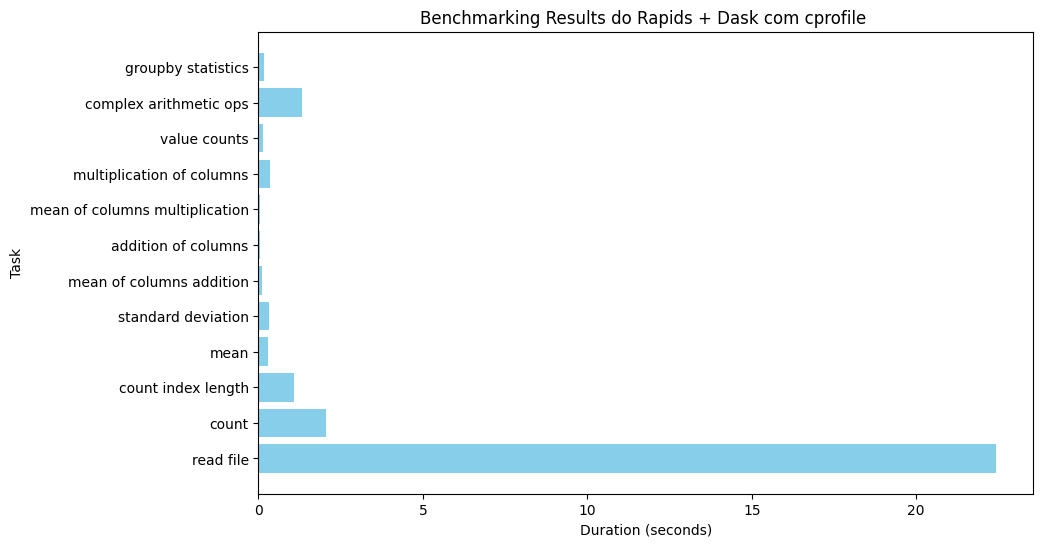

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_rapids['task'], results_rapids['duration'], color='skyblue')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Rapids + Dask com cprofile ')
plt.show()

### Gráfico Pizza

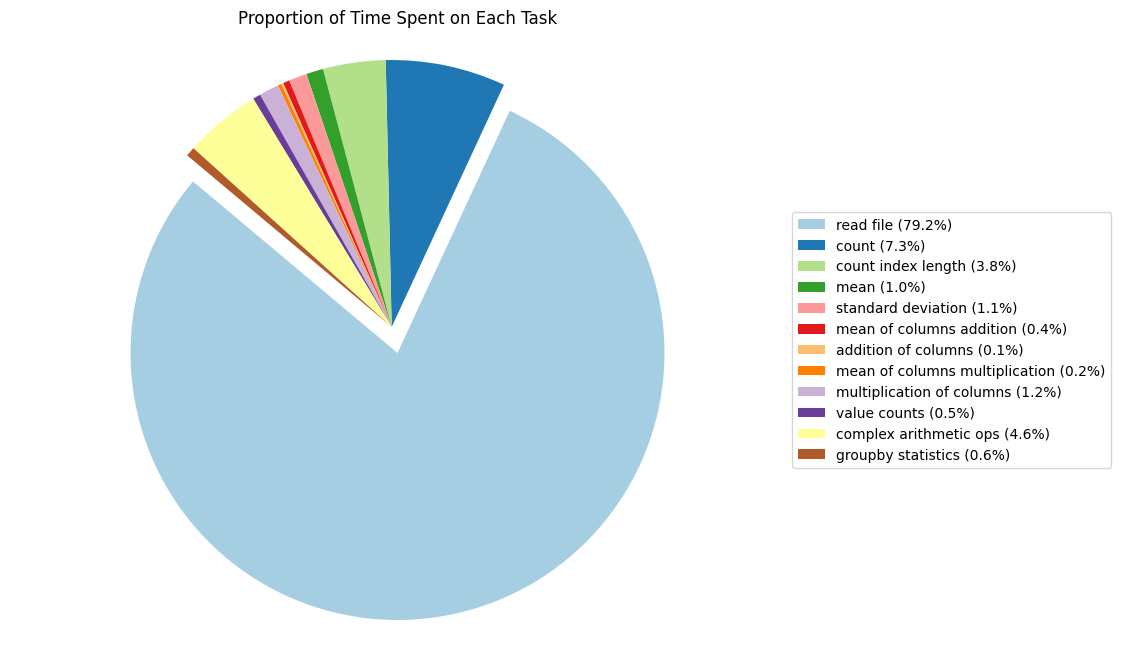

In [ ]:
# Calcular percentagens
percentages = [f"{(d / sum(results_rapids['duration']) * 100):.1f}%" for d in results_rapids['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_rapids['task'], percentages)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_rapids['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_rapids['duration'], startangle=140, colors=plt.cm.Paired.colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()



### Gráfico de Linhas

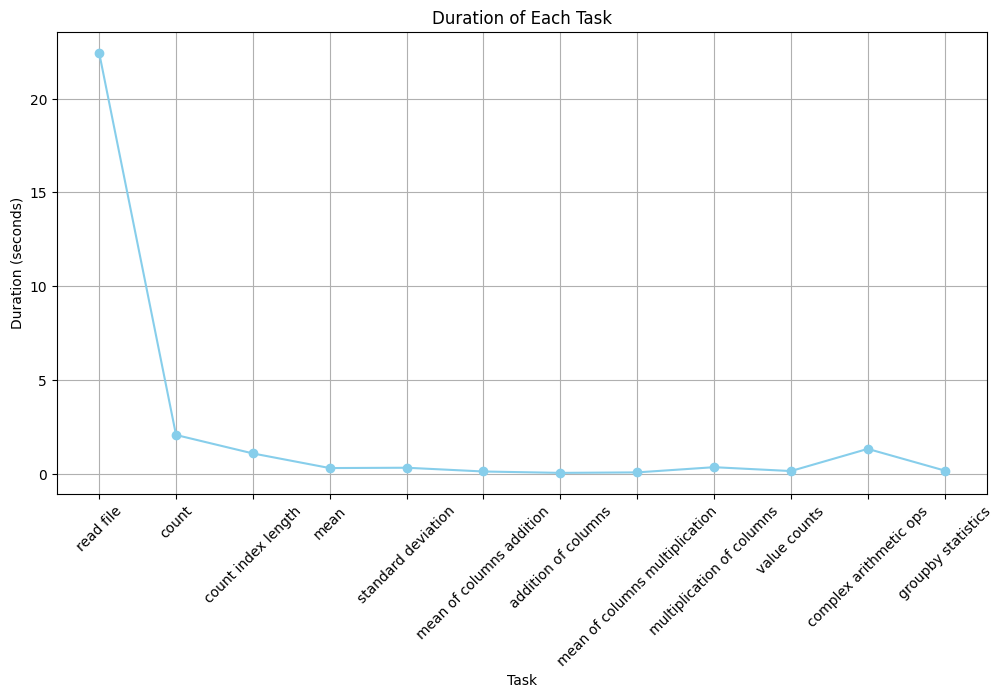

In [ ]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_rapids['task'], results_rapids['duration'], marker='o', linestyle='-', color='skyblue')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### cProfile em dados filtrados

In [ ]:
rapids_benchmarks_filtered_cprofile = {'duration': [], 'task': []}

In [ ]:
# Executar benchmarks nas operações com dados filtrados
benchmark_with_cprofile(read_file_parquet, df=None, benchmarks=rapids_benchmarks_filtered_cprofile, name='read file')
benchmark_with_cprofile(count, df=rapids_filtered, benchmarks=rapids_benchmarks_filtered_cprofile, name='count')
benchmark_with_cprofile(count_index_length, df=rapids_filtered, benchmarks=rapids_benchmarks_filtered_cprofile, name='count index length')
benchmark_with_cprofile(mean, df=rapids_filtered, benchmarks=rapids_benchmarks_filtered_cprofile, name='mean')
benchmark_with_cprofile(standard_deviation, df=rapids_filtered, benchmarks=rapids_benchmarks_filtered_cprofile, name='standard deviation')
benchmark_with_cprofile(mean_of_sum, df=rapids_filtered, benchmarks=rapids_benchmarks_filtered_cprofile, name='mean of columns addition')
benchmark_with_cprofile(sum_columns, df=rapids_filtered, benchmarks=rapids_benchmarks_filtered_cprofile, name='addition of columns')
benchmark_with_cprofile(mean_of_product, df=rapids_filtered, benchmarks=rapids_benchmarks_filtered_cprofile, name='mean of columns multiplication')
benchmark_with_cprofile(product_columns, df=rapids_filtered, benchmarks=rapids_benchmarks_filtered_cprofile, name='multiplication of columns')
benchmark_with_cprofile(value_counts, df=rapids_filtered, benchmarks=rapids_benchmarks_filtered_cprofile, name='value counts')
benchmark_with_cprofile(complicated_arithmetic_operation, df=rapids_filtered, benchmarks=rapids_benchmarks_filtered_cprofile, name='complex arithmetic ops')
benchmark_with_cprofile(groupby_statistics, df=rapids_filtered, benchmarks=rapids_benchmarks_filtered_cprofile, name='groupby statistics')


INFO:distributed.core:Event loop was unresponsive in Scheduler for 11.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 11.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


A saída de streaming foi truncada nas últimas 5000 linhas.
       80    0.000    0.000    0.000    0.000 {built-in method builtins.getattr}
       32    0.000    0.000    0.000    0.000 generic.py:42(_instancecheck)
        2    0.000    0.000    0.000    0.000 blockwise.py:667(_get_coord_mapping)
        8    0.000    0.000    0.000    0.000 blockwise.py:1334(<listcomp>)
        8    0.000    0.000    0.000    0.000 blockwise.py:1185(_unique_dep)
        1    0.000    0.000    0.000    0.000 client.py:1066(current)
        2    0.000    0.000    0.000    0.000 config.py:260(__call__)
        1    0.000    0.000    0.000    0.000 core.py:412(_toposort)
      8/4    0.000    0.000    0.000    0.000 core.py:90(_execute_task)
        1    0.000    0.000    0.000    0.000 base.py:820(_engine)
        3    0.000    0.000    0.000    0.000 uuid.py:138(__init__)
       22    0.000    0.000    0.000    0.000 base.py:229(construct_from_string)
        2    0.000    0.000    0.000    0.000 delay

0.22542381286621094

In [ ]:
results_rapids_filtered = pd.DataFrame.from_dict(rapids_benchmarks_filtered_cprofile)

### Gráfico de barras

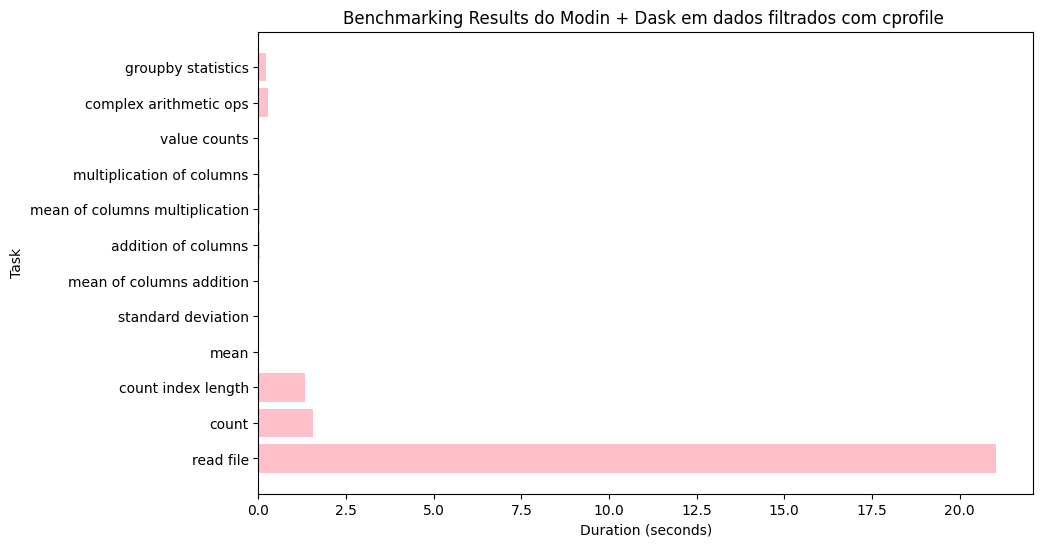

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_rapids_filtered['task'], results_rapids_filtered['duration'], color='pink')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Modin + Dask em dados filtrados com cprofile ')
plt.show()

### Gráfico Pizza

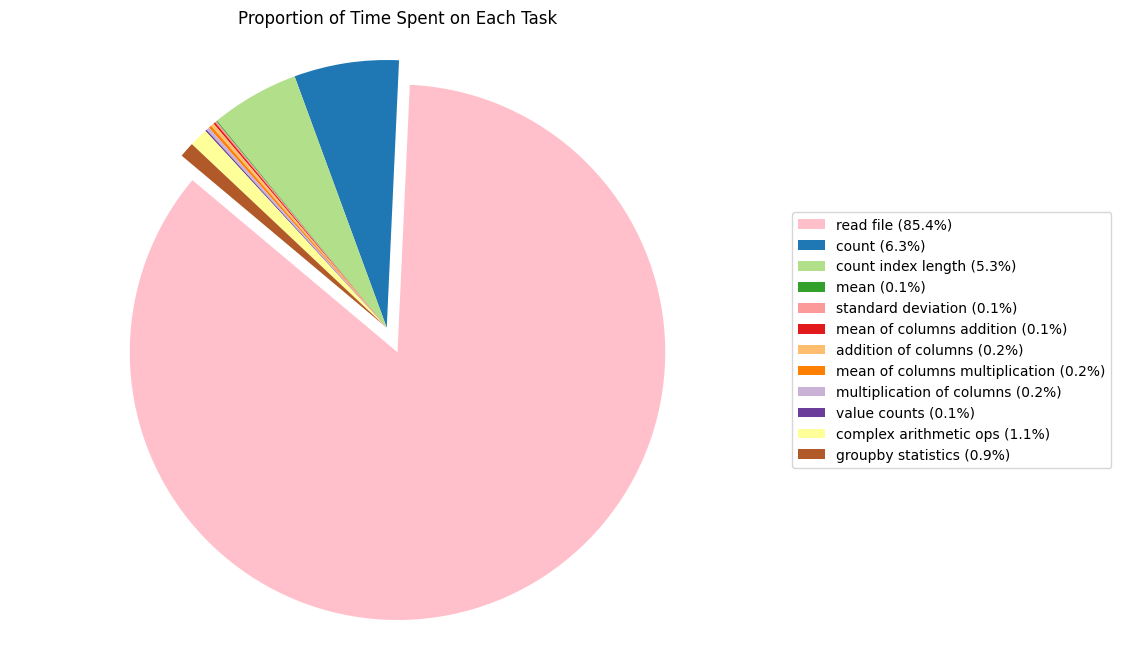

In [ ]:
# Calcular percentagens
percentages = [f"{(d / sum(results_rapids_filtered['duration']) * 100):.1f}%" for d in results_rapids_filtered['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_rapids_filtered['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['pink' if task == 'read file' else color for task, color in zip(results_rapids_filtered['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_rapids_filtered['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_rapids_filtered['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Gráfico de Linhas

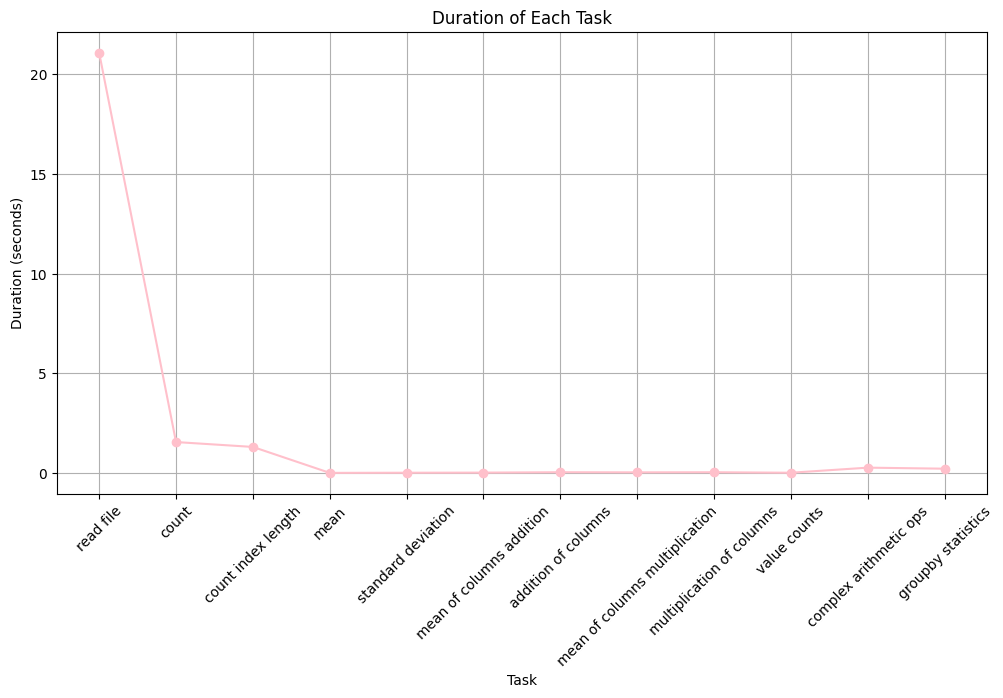

In [ ]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_rapids_filtered['task'], results_rapids_filtered['duration'], marker='o', linestyle='-', color='pink')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Ao executar o cProfile em dados com cache no Google Colab ocorreu um erro de memória do GPU, logo não foi possível avaliar o resto dos datasets com cProfile.

### Conclusão
Os gráficos mostram claramente que a operação de leitura de ficheiro (`read_file`) é a mais intensiva em termos de tempo de execução, representando cerca de 85,4% do tempo total, seguida pelas operações de contagem (`count` e `count index length`). As restantes operações representam uma fração muito menor do tempo total de execução.